In [23]:
import numpy as np
import pandas as pd

from src.hrv_epatch.io.labview import read_labview_rr, read_header_datetime_lvm
from src.hrv_epatch.io.data_loader import Load_full_ecg_data

from src.hrv_epatch.rpeak.compare import (
    match_rpeaks_pairwise_verbose,
    plot_match_regions,
    plot_FP_FN_overview,
    FN_in_seizures,
    FN_near_seizures,
)


In [24]:
import re

# === SETTINGS ===
PATIENT = "Patient 5"
# PATH_LVM = fr"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\{PATIENT}_1-Res1.lvm"*
PATH_LVM = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_remove_s35_e30.lvm"

KNOWN_OFFSET_S = -0.065   # det du fandt fungerede
TOL_MS = 40.0

# Extract the value after '_s' in the file path
match = re.search(r'_s(\d+)', PATH_LVM)
if match:
    crop_start_min = int(match.group(1))
else:
    crop_start_min = 0  # Default to 0 if no match is found

# Extract the value after '_e' in the file path
match = re.search(r'_e(\d+)', PATH_LVM)
if match:
    crop_end_min = int(match.group(1))
else:
    crop_end_min = 0  # Default to 0 if no match is found

CROP_START_S = crop_start_min * 60  # Convert minutes to seconds
CROP_END_S = crop_end_min * 60      # Convert minutes to seconds

# print(f"Crop start: {CROP_START_S} s, Crop end: {CROP_END_S} s")
# print(f"Known offset: {KNOWN_OFFSET_S} s, Tolerance: {TOL_MS} ms")
# print(f"Patient: {PATIENT}")

# print(f"SanityCheck: {crop_start_min=} min, {crop_end_min=} min")


In [25]:
rr_intervals_lv = read_labview_rr(PATH_LVM)
starttime_lv = read_header_datetime_lvm(PATH_LVM)

res = Load_full_ecg_data(PATIENT)
fs = res["SampleRate"]

print(f"Loaded ECG with {len(res['ECG'])} samples")
print(f"Loaded {len(rr_intervals_lv)} LabVIEW RR intervals")


[DEBUG] Potentielle annoteringsfiler for Patient 5:
    Patient 5.xls
  - Læser seizure-log fra: E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures - excluded seizures removed\Patient 5.xls
Loaded ECG with 82460288 samples
Loaded 165242 LabVIEW RR intervals


In [26]:
print(res.keys())

dict_keys(['PatientID', 'ECG', 'Seizures', 'SampleRate', 'StartTime', 'TdmsPath'])


In [27]:
# compute crop start based on TDMS vs LabVIEW alignment
time_to_drop_start = starttime_lv.timestamp() - res['StartTime'].timestamp()
samples_to_drop_start = int(time_to_drop_start * fs)
samples_to_drop_end = int(CROP_END_S * fs)

ecg_segment = res["ECG"].iloc[samples_to_drop_start:-samples_to_drop_end]
ecg_signal = ecg_segment["Value"].to_numpy()

print(f"ECG segment length: {len(ecg_signal)} samples")


ECG segment length: 80454660 samples


In [28]:
import neurokit2 as nk

cleaned_ecg = nk.ecg_clean(ecg_signal, sampling_rate=fs)
r_peaks = nk.ecg_peaks(cleaned_ecg, sampling_rate=fs)[0]
detected_r_peaks = np.flatnonzero(r_peaks["ECG_R_Peaks"])


In [29]:
labview_r_peaks = np.cumsum(np.insert(rr_intervals_lv, 0, 0)) * fs
labview_r_peaks = np.round(labview_r_peaks).astype(int)


In [30]:
res_verbose = match_rpeaks_pairwise_verbose(
    gold_idx=labview_r_peaks,
    test_idx=detected_r_peaks,
    fs=fs,
    tol_ms=TOL_MS,
    known_offset_s=KNOWN_OFFSET_S,
)

res_verbose


{'TP': 165185,
 'FP': 118,
 'FN': 57,
 'Sensitivity': 0.9996550513791893,
 'PPV': 0.9992861593558495,
 'F1': 0.9994705713291685,
 'TP_idx_gold': array([     508,     1026,     1530, ..., 80453147, 80453569, 80454005],
       shape=(165185,)),
 'FN_idx_gold': array([ 9725581, 11285015, 13878437, 32488195, 43270699, 50031678,
        50032941, 50039661, 50040020, 51535438, 51538213, 51539317,
        51539730, 51540165, 51540482, 51540731, 51540875, 51541079,
        51541219, 51541623, 51542134, 51542374, 51543227, 51543410,
        51543592, 51543742, 51543892, 51544099, 51544283, 51544492,
        51545035, 51545457, 51546116, 51546441, 51546654, 51546834,
        51547193, 51547374, 51547735, 51547915, 51548144, 51548516,
        51549181, 51549415, 51550093, 51550823, 51551057, 51551386,
        51552013, 51552561, 51552715, 51557170, 68203215, 77285852,
        80117027, 80117387, 80117637]),
 'TP_idx_test': array([     506,     1024,     1529, ..., 80453145, 80453568, 80454005],
 

In [31]:
shift_samples = int(round(KNOWN_OFFSET_S * fs))

# Flyt LabVIEW-peaks, så de aligner til NeuroKit/ECG-aksen
labview_r_peaks_plot = labview_r_peaks + shift_samples

# Re-match UDEN offset, men nu med de flyttede gold-peaks
res_plot = match_rpeaks_pairwise_verbose(
    gold_idx=labview_r_peaks_plot,
    test_idx=detected_r_peaks,
    fs=fs,
    tol_ms=TOL_MS,
    known_offset_s=None,  # vigtigt: ingen offset her!
)

# Tjek at metrics stadig er de samme
print(res_plot["TP"], res_plot["FP"], res_plot["FN"])


165185 118 57


In [32]:
import pandas as pd
import numpy as np

def build_seizure_windows_from_res(res, fs: float):
    """
    Tag res-dict'et fra Load_full_ecg_data og byg:
      - et clean DataFrame med t0/t1 i sekunder fra ECG-start
      - en liste af (start_sample, end_sample) til FP/FN-plots

    Forventer at res["Seizures"] indeholder:
      - en dato-kolonne med 'Dato' i navnet
      - en start-kolonne med 'Anfaldsstart Klinisk' i navnet
      - en stop-kolonne med 'Anfaldstop Klinisk' i navnet
    """
    seiz_raw = res["Seizures"].copy()
    ecg_start = res["StartTime"]

    # sørg for simple str-kolonnenavne
    seiz_raw.columns = [str(c).strip() for c in seiz_raw.columns]
    cols = seiz_raw.columns

    # find relevante kolonner via substring-match
    date_col = next(c for c in cols if "Dato" in c)
    start_col = next(c for c in cols if "Anfaldsstart Klinisk" in c)
    stop_col  = next(c for c in cols if "Anfaldstop Klinisk" in c)

    # build datetimes fra dato + tid (dd.mm.yy HH:MM:SS)
    start_dt = pd.to_datetime(
        seiz_raw[date_col].astype(str).str.strip() + " " +
        seiz_raw[start_col].astype(str).str.strip(),
        format="%d.%m.%y %H:%M:%S",
        errors="coerce"
    )
    stop_dt = pd.to_datetime(
        seiz_raw[date_col].astype(str).str.strip() + " " +
        seiz_raw[stop_col].astype(str).str.strip(),
        format="%d.%m.%y %H:%M:%S",
        errors="coerce"
    )

    # ecg_start kan være tz-aware; vi gør den naiv for konsistent differens
    ecg_start_naive = pd.to_datetime(ecg_start).tz_localize(None) \
        if getattr(ecg_start, "tzinfo", None) is not None else pd.to_datetime(ecg_start)

    # t0/t1 i sekunder fra recording start
    t0 = (start_dt - ecg_start_naive).dt.total_seconds()
    t1 = (stop_dt  - ecg_start_naive).dt.total_seconds()

    # lav clean DataFrame
    seiz_clean = pd.DataFrame({
        "seizure_id": np.arange(1, len(seiz_raw) + 1),
        "start_dt": start_dt,
        "end_dt": stop_dt,
        "t0": t0,
        "t1": t1,
    })

    # filtrér evt. rækker uden gyldige tider
    seiz_clean = seiz_clean.dropna(subset=["t0", "t1"])

    # samples
    seiz_clean["start_sample"] = (seiz_clean["t0"] * fs).round().astype(int)
    seiz_clean["end_sample"]   = (seiz_clean["t1"] * fs).round().astype(int)

    # liste af (start_sample, end_sample)
    windows = list(zip(seiz_clean["start_sample"], seiz_clean["end_sample"]))

    return seiz_clean, windows


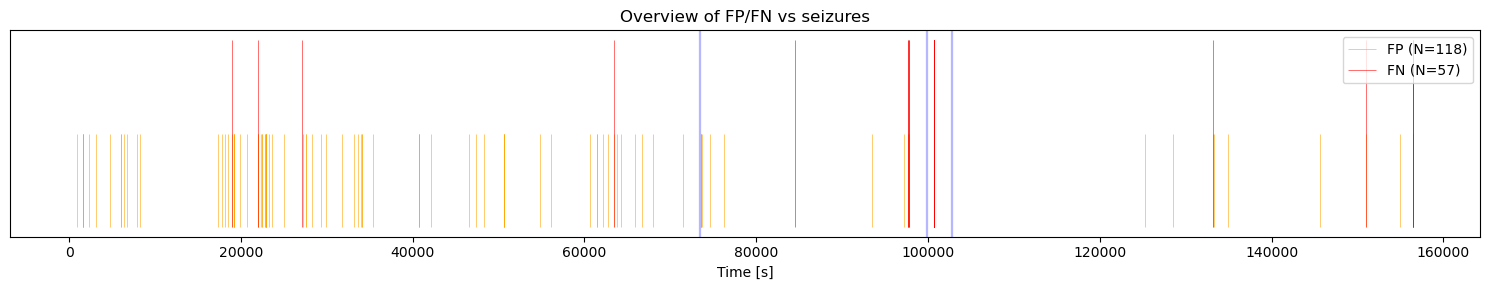

In [33]:
seizure_df_clean, seizure_windows = build_seizure_windows_from_res(res, fs)

plot_FP_FN_overview(res_plot, fs=fs, seizures=seizure_windows)


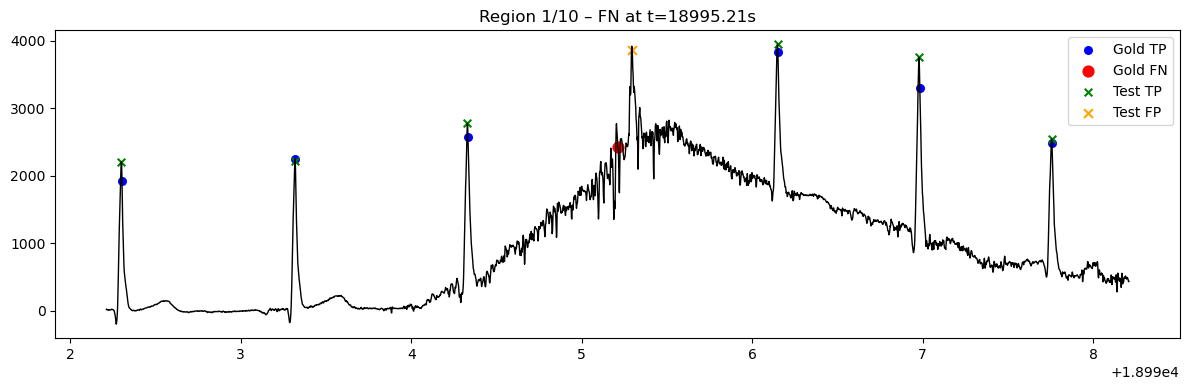

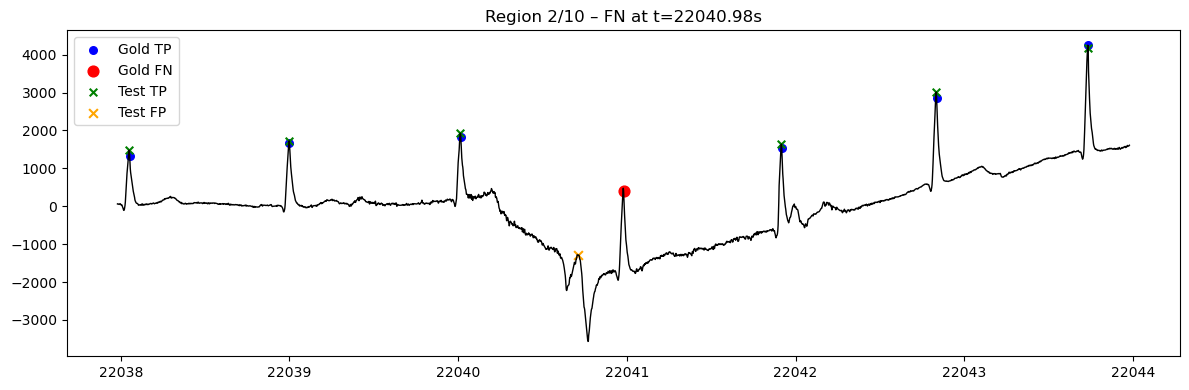

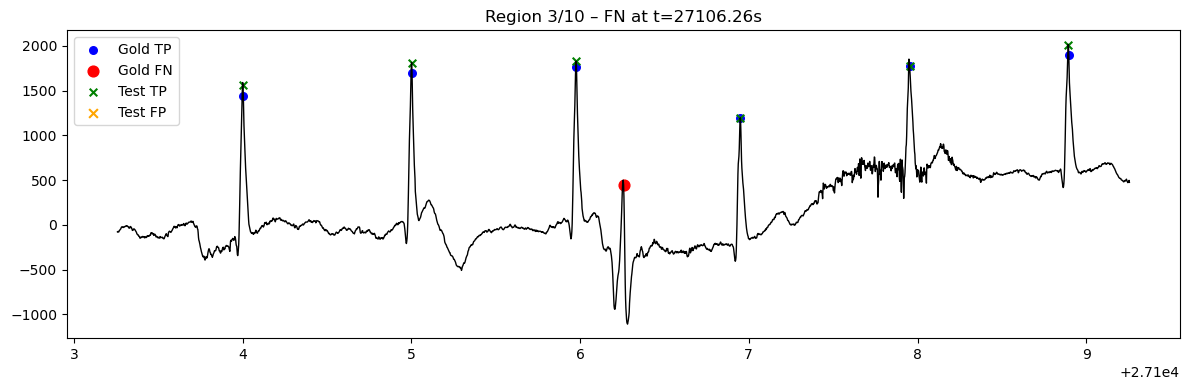

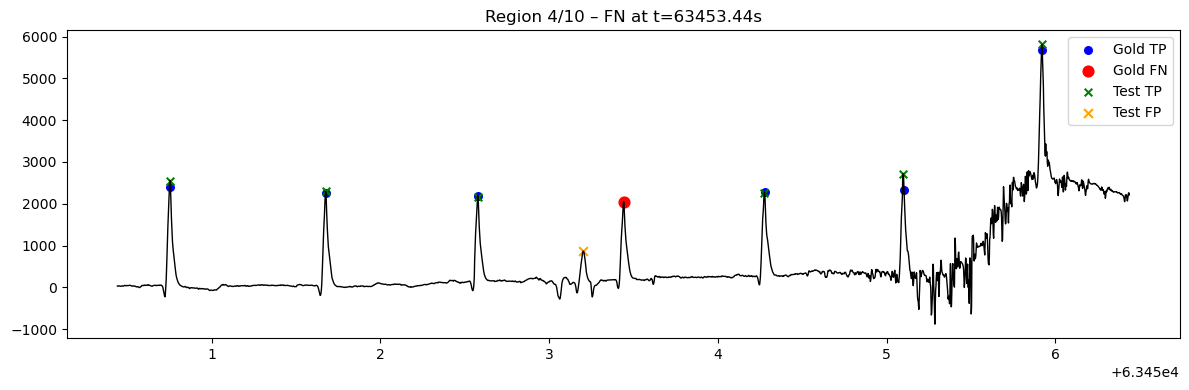

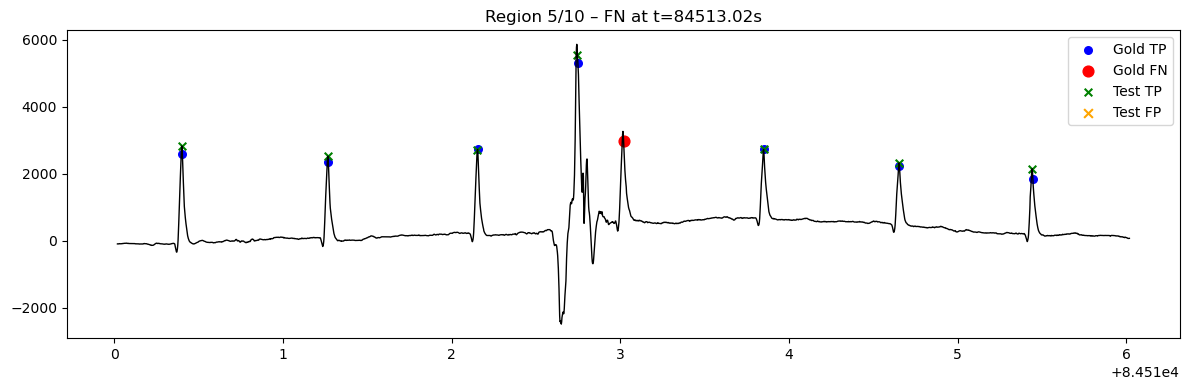

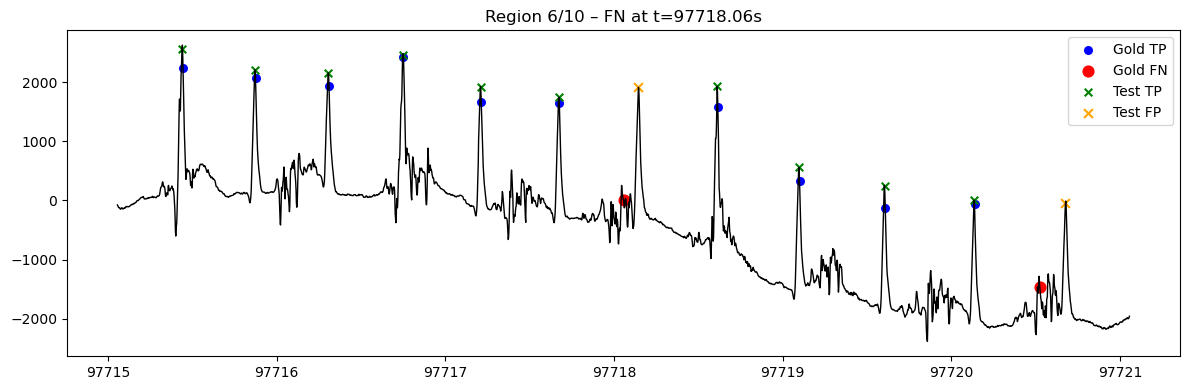

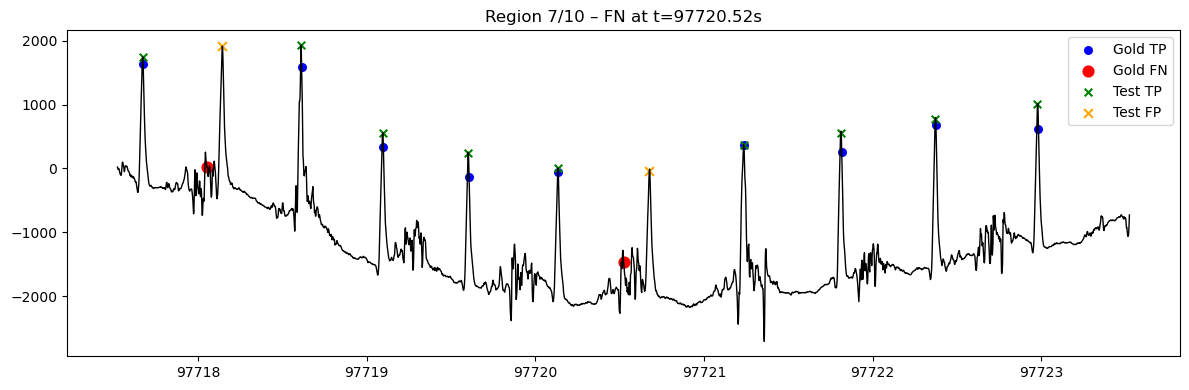

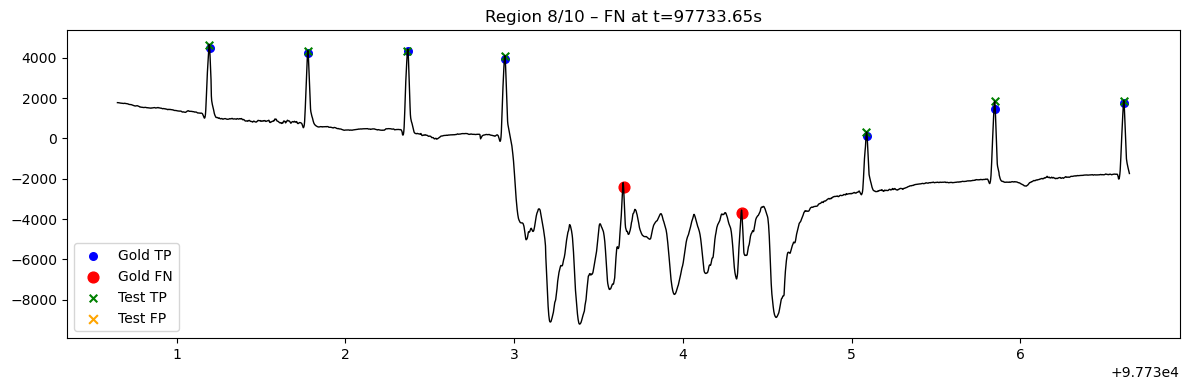

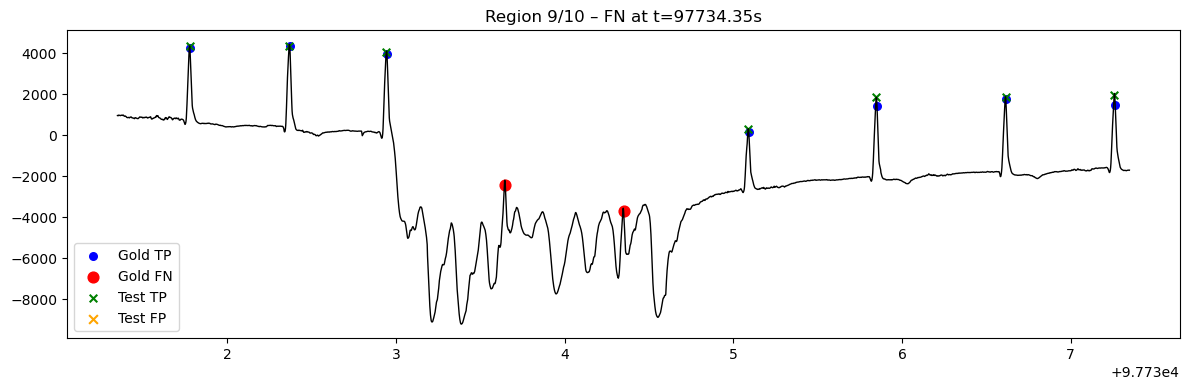

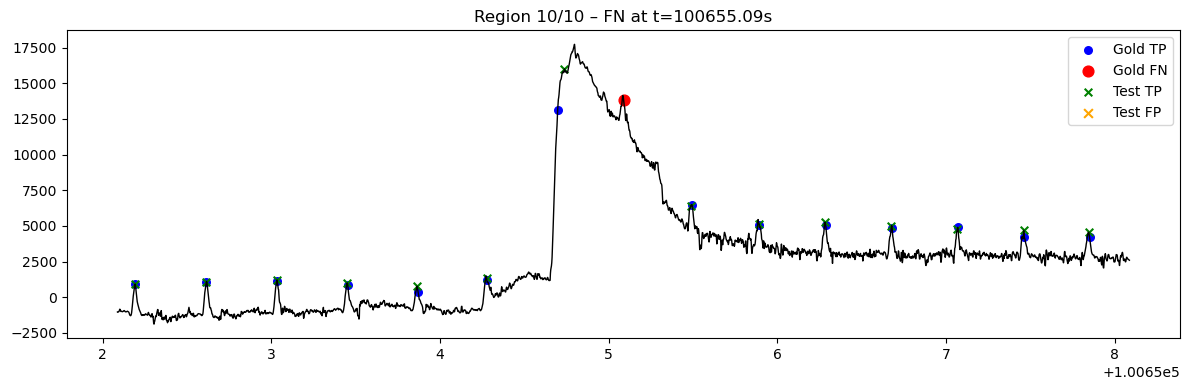

In [34]:
plot_match_regions(
    ecg=ecg_signal,
    fs=fs,
    res=res_plot,      # <-- brug plot-versionen
    window_s=3.0,
    max_plots=10,
    min_time_s=0.0,
)


In [19]:
seizure_df_clean, seizure_windows = build_seizure_windows_from_res(res, fs)

print(seizure_df_clean[["seizure_id", "t0", "t1", "start_sample", "end_sample"]])


   seizure_id        t0        t1  start_sample  end_sample
0           1   73315.0   73435.0      37537280    37598720
1           2   99768.0   99861.0      51081216    51128832
2           3  102686.0  102816.0      52575232    52641792


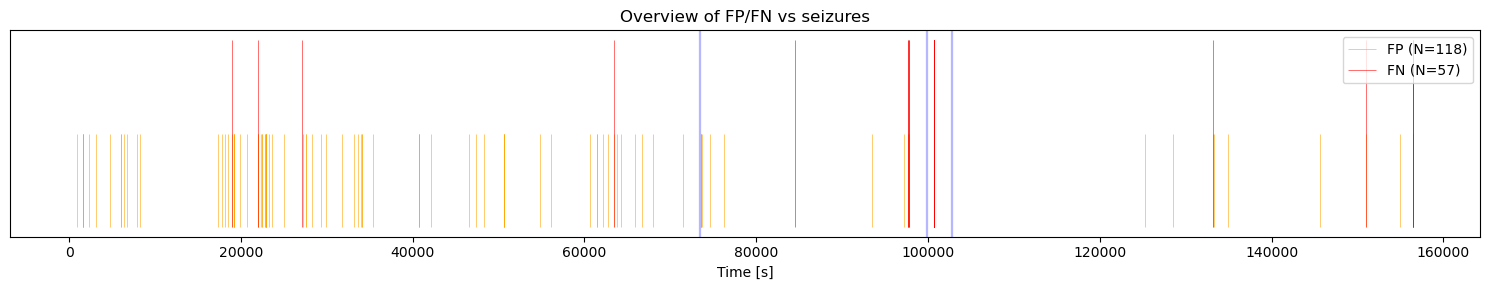

FNs inside seizures: 0
FNs outside seizures: 57
FNs inside or within 5s of seizures: 0; far from seizures: 57


In [20]:
plot_FP_FN_overview(res_verbose, fs=fs, seizures=seizure_windows)

FN_idx = res_verbose["FN_idx_gold"]
inside, outside = FN_in_seizures(FN_idx, seizure_windows)
inside_or_near, far = FN_near_seizures(FN_idx, seizure_windows, fs, buffer_s=5)

print(f"FNs inside seizures: {len(inside)}")
print(f"FNs outside seizures: {len(outside)}")
print(f"FNs inside or within 5s of seizures: {len(inside_or_near)}; far from seizures: {len(far)}")


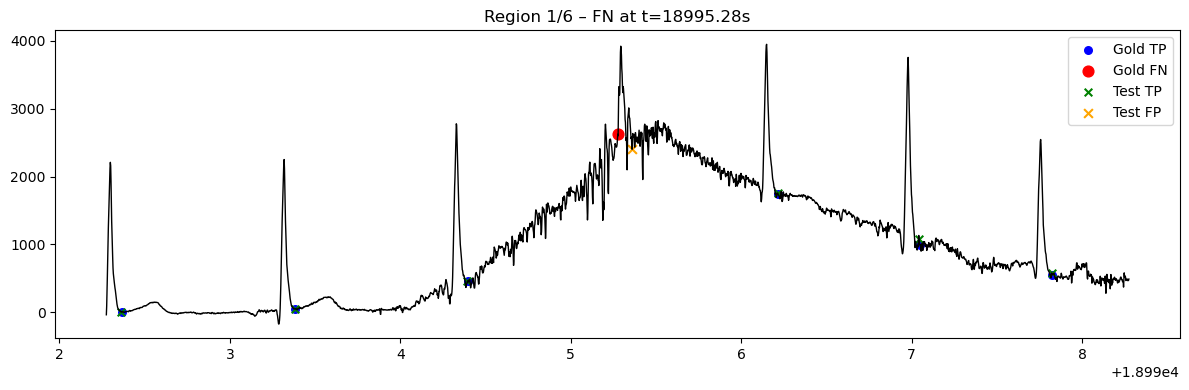

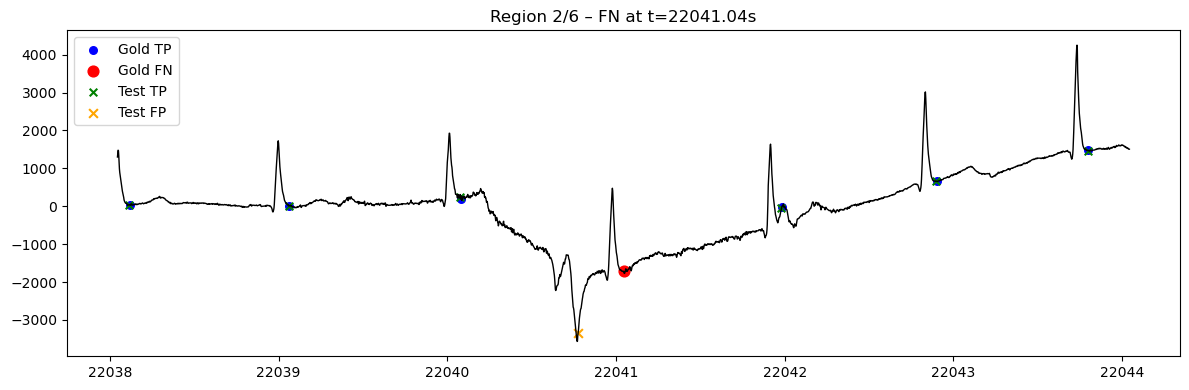

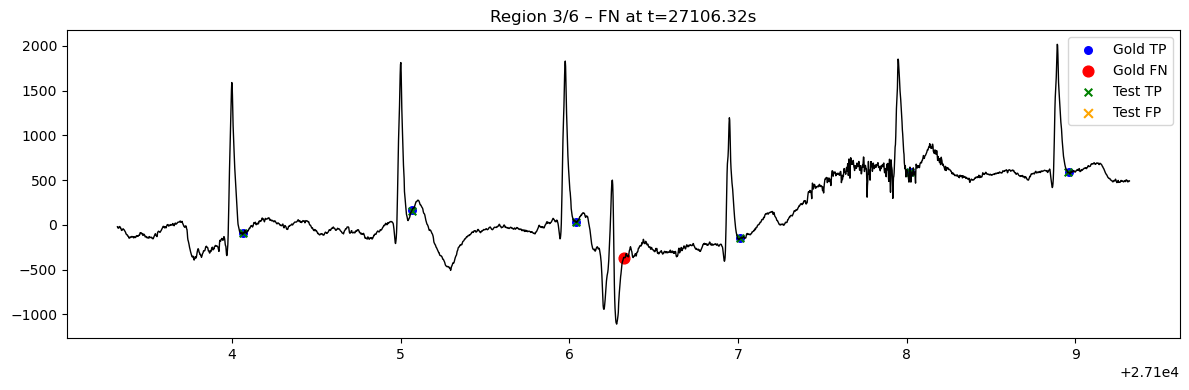

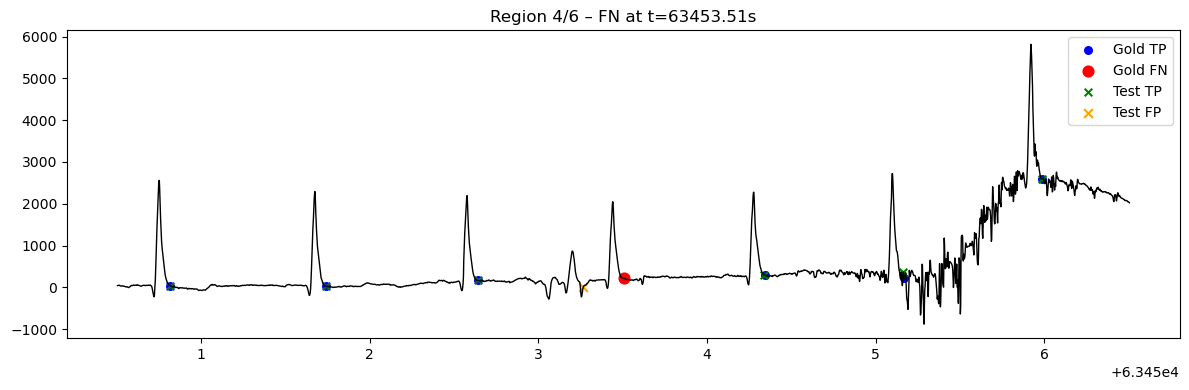

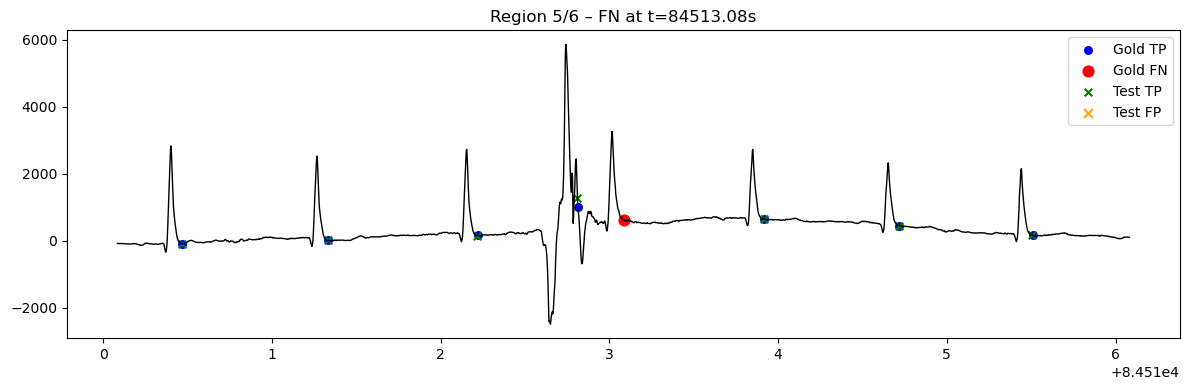

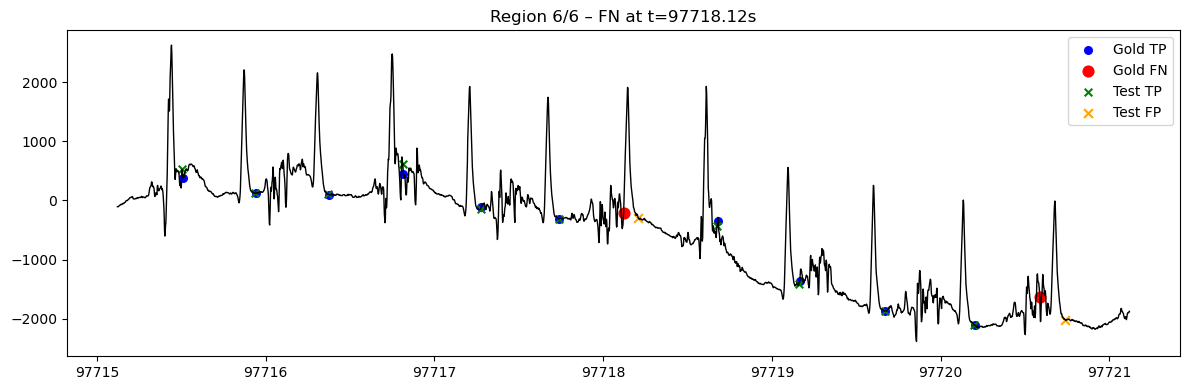

In [21]:
plot_match_regions(
    ecg=ecg_signal,
    fs=fs,
    res=res_verbose,
    window_s=3.0,
    max_plots=6,
    min_time_s=5000.0,      # user can adjust here
)


In [25]:
plot_match_regions(
    ecg=ecg_signal,
    fs=fs,
    res=res_plot,   # se næste afsnit
    window_s=3.0,
    max_plots=10,
    min_time_s=0.0,
)


NameError: name 'res_plot' is not defined